## Parte 1 - Identificar lo fraudes potenciales con un SOM

In [1]:
# Importar las librerías

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Importar el dataset

dataset = pd.read_csv('Credit_Card_Applications.csv')

In [3]:
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [4]:
# necesito todos los atributos menos el último que es la clase -> etiqueta que no necesitamos porque los som no son supervisados (0= solicitud aprobada; 1= solicitud no aprobada)
X = dataset.iloc[:,:-1].values # Tengo 15 columnas pero la primera no la considero (ID del cliente). La dejo sólo para saber de quién se trata
y = dataset.iloc[:,-1].values

In [5]:
# Escalado de las características

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler (feature_range= (0,1))
X= sc.fit_transform(X)

In [6]:
from minisom import MiniSom


In [7]:
som = MiniSom(x = 10, y =10, input_len= 15, sigma = 1.0, learning_rate= 0.5) #porque quiero una cuadrícula de  10 filas y 10 columnas
# sigma -> radio inicial. Por defecto =1. Luego se va actualizando en el interior del propio algoritmo
# learning_rate=0.5 . Capacidad de ir adaptando el valor de los pesos de una iteración a la siguiente. Por defecto. Puedo ser más alto. Aprenderá más rápido pero puede pasarse de frenada
# decay_function = none -> Función de desintegración se puede usar para mejorar la convergencia

In [8]:
# Hay que inicializar el vector de pesos a números pequeños cercanos a cero (pero no 0)
som.random_weights_init(X)


In [9]:
# Proceder al entrenamiento
som.train_random(data = X, num_iteration = 100)

In [10]:
# Visualizar los resultados
from pylab import bone, pcolor, colorbar, plot, show

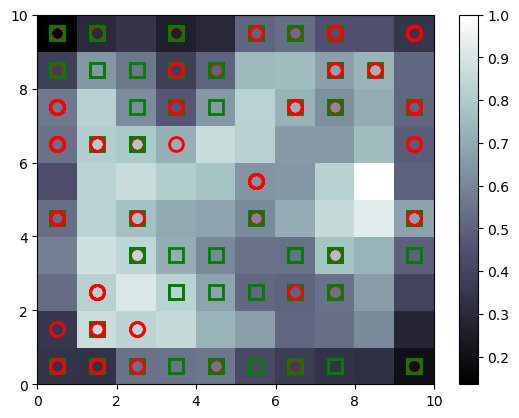

In [11]:
# bone me permite establecer la ventana de dibujo
bone()
# Detectar los nodos ganadores del mapa
#pcolor permite establecer un gradiente para poder agregar colores de distancias medias
# para obtener las disstancias -> método de las distancias entre las neuronas
#Las distancias vienen en columna y las necesito en fila -> transponer
pcolor(som.distance_map().T)
# Pintamos una leyenda
colorbar()

# a qué cliente/s corresponde el recuadro blanco?
markers =['o', 's'] # marcador círculo : o, cuadrado; s #primera opcion obtuvo autorización, segunda opción: no obtuvo la autorización
colors = ['r', 'g'] # los círculos serán rojos y los marcadores serán verde
for i, x in enumerate(X): # i para posición y x para valores específicos
    w = som.winner(x) # nodo ganador. Nos da fila y columna
    plot(w[0]+0.5,w[1]+0.5,
         markers[y[i]], markeredgecolor = colors[y[i]], markerfacecolor ='None', 
         markersize = 10, markeredgewidth =2) # sumo 0.5 para que el nodo ganador esté en el centro del cuadrado. Antes estaba en la esquina inferior  izquierda
show()

In [12]:
# encontrar los fraudes

mappings = som.win_map(X)
frauds= np.concatenate((mappings[(2,3)], mappings[(3,3)]), axis = 0) # va en tupla, ojo!

In [13]:
# desecalar los valores

frauds = sc.inverse_transform(frauds)

In [14]:
frauds

array([[1.5753591e+07, 1.0000000e+00, 2.6750000e+01, 1.1250000e+00,
        2.0000000e+00, 1.4000000e+01, 8.0000000e+00, 1.2500000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.0000000e+00, 0.0000000e+00, 5.2990000e+03],
       [1.5797246e+07, 1.0000000e+00, 2.3420000e+01, 5.8500000e-01,
        2.0000000e+00, 8.0000000e+00, 8.0000000e+00, 8.5000000e-02,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.0000000e+00, 1.8000000e+02, 1.0000000e+00],
       [1.5778142e+07, 1.0000000e+00, 2.2080000e+01, 1.1000000e+01,
        2.0000000e+00, 1.3000000e+01, 4.0000000e+00, 6.6500000e-01,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.0000000e+00, 1.0000000e+02, 1.0000000e+00],
       [1.5812918e+07, 1.0000000e+00, 4.1750000e+01, 9.6000000e-01,
        2.0000000e+00, 1.4000000e+01, 4.0000000e+00, 2.5000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.0000000e+00,

## Parte 2 - Trasladar el modelo de Deep Learning de no supervisado a supervisado

### Crear la matriz de características

In [15]:
Customers = dataset.iloc[:,1:-1].values #Será la X de antes. Cada línea un cliente y cada columna es una información (característica) del mismo. Empezamos en columna 1 para excluir la ID

# =1 si el SOM ha detectado que es fraudulento y 0 si no


In [18]:
Customers

array([[1.000e+00, 2.208e+01, 1.146e+01, ..., 2.000e+00, 1.000e+02,
        1.213e+03],
       [0.000e+00, 2.267e+01, 7.000e+00, ..., 2.000e+00, 1.600e+02,
        1.000e+00],
       [0.000e+00, 2.958e+01, 1.750e+00, ..., 2.000e+00, 2.800e+02,
        1.000e+00],
       ...,
       [0.000e+00, 1.883e+01, 9.540e+00, ..., 2.000e+00, 1.000e+02,
        1.000e+00],
       [0.000e+00, 2.742e+01, 1.450e+01, ..., 2.000e+00, 1.200e+02,
        1.200e+01],
       [1.000e+00, 4.100e+01, 4.000e-02, ..., 1.000e+00, 5.600e+02,
        1.000e+00]])

### Crear la variable dependiente

In [19]:
is_fraud = np.zeros(len(dataset)) # Creo una matriz de ceros del tamaño de nuestro dataset. Inicializamos todos con ceros -> Suponemos que no hay fraudes

In [20]:
# Tenemos que añadir los unos correspondientes a las salidas  de frauds

for i in range(len(dataset)):
    if dataset.iloc[i, 0] in frauds:
        is_fraud[i]= 1

In [21]:
is_fraud

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [22]:
# Escalado de características (Feature Scaling)
# Fundamental en Redes Neuronales
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Customers = sc.fit_transform(Customers)
# la variable dependiente nio hace falta por que ya la tenemos arriba -> is_fraud

## PARTE 2- CONSTRUIR LA RNA (Red Neuronal Artificial)

# Importar Keras y librerías adicionales

In [23]:
from tensorflow import keras
from tensorflow.keras.models import Sequential #Para inicializar los parámetros de la Red Neuronal
from tensorflow.keras.layers import Dense # Para declarar y crear las capas intermedias de la Red Neuronal
from tensorflow.keras.layers import Dropout # Para crear la capa de dropout (de olvido) - útil cuando tenemos mucha varianza - Evita overfitting desactivando algunas neurones de la capa inmediatamente anterior 

## PARTE 3- CONSTRUIR LA RNA

In [24]:
# Inicializar la RNA
classifier = Sequential()


In [25]:
# Añadir capas de entrada y primeras capa oculta
# Paso 1 - Inicializar los pesos aleatoriamente con valores cercanos a 0 (pero no 0)
classifier.add(Dense(units = 2, kernel_initializer = 'uniform', activation = "relu", input_dim = 14 )) # La entrada son 14 características. Con 2 neuronas irá bien


In [26]:
# Añadir la capa de salida
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = "sigmoid"))
# en la capa de salida quiero una probabilidad -> función de activació: función sigmoide

In [27]:
# Compilar la RNA
classifier.compile(optimizer = "adam", loss = "binary_crossentropy", metrics=["accuracy"])

In [28]:
# Ajustamos la RNA al conjunto de entrenamiento (Paso 2)
classifier.fit(Customers,is_fraud, batch_size=1, epochs = 2)
#batch_size=10 -> procesar 10 elementos -> Corregir los pesos -> procesar 10 elementos -> Corregir los pesos (más óptimo)
#epochs=100 -> Dará 100 pasadas a nuestros datos

Epoch 1/2
690/690 [==============================] - 1s 972us/step - loss: 0.4348 - accuracy: 0.9899
Epoch 2/2
690/690 [==============================] - 1s 977us/step - loss: 0.1131 - accuracy: 0.9899


# Parte 3 - Evaluar el modelo y calcular predicciones  finales

In [40]:
np.set_printoptions(suppress=True) # Para que numpy no muestre las celdas numérica como numeros con potencias

In [41]:
# Predicción de los resultados con el conjunto de Testing
y_pred = classifier.predict(Customers)
# necesito una estructura de 2 columnas cliente / Probabilidad de fraude
y_pred = np.concatenate((dataset.iloc[:,0:1].values, y_pred), axis=1) 
# quiero del dataset todas las filas y la primera columna (0) pero pongo de 0:1 para que me de la 0 con formato 2D y poder concatenar con y_pred que es de 2D
# concatenate va en tupla
#axis= 1 -> Para que la concatencación sea por columnas (no por filas)

22/22 [==============================] - 0s 583us/step


In [42]:
y_pred

array([[15776156.        ,        0.0338155 ],
       [15739548.        ,        0.03702997],
       [15662854.        ,        0.02552815],
       ...,
       [15675450.        ,        0.03696153],
       [15776494.        ,        0.037566  ],
       [15592412.        ,        0.08007167]])

In [43]:
#odenamos la matriz numpy con arrsort
y_pred[y_pred[:,1].argsort()[::-1]]

# argsort()[::-1]] -> argsort() ordena de menor a mayor.  Para que sea de mayor a menor añado [::-1]]

array([[15735572.        ,        0.32799122],
       [15594133.        ,        0.30181265],
       [15784526.        ,        0.2641702 ],
       ...,
       [15654859.        ,        0.00533857],
       [15621423.        ,        0.00375008],
       [15799785.        ,        0.00226754]])